In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('/content/data.ai.csv')

In [3]:
print(data.head())


         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimeter_worst  area_worst  smoothness

In [4]:
data['diagnosis'] = data['diagnosis'].map({'M':1,'B':0})

In [5]:
x=data.drop(columns=['diagnosis']).values
y=data['diagnosis'].values

In [6]:
def normalize(x): return (x-x.min(axis=0))/(x.max(axis=0)-x.min(axis=0))
x=normalize(x)

In [7]:
def train_test_split(x, y, test_size=0.2):
    np.random.seed(42)
    indices = np.random.permutation(len(x))
    test_count = int(len(x) * test_size)

    test_idx = indices[:test_count]
    train_idx = indices[test_count:]

    return x[train_idx], x[test_idx], y[train_idx], y[test_idx]

x_train, x_test, y_train, y_test = train_test_split(x, y)

In [8]:
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

def manhattan_distance(a, b):
    return np.sum(np.abs(a - b))

def minkowski_distance(a, b, p=3):
    return np.sum(np.abs(a - b) ** p) ** (1/p)

def cosine_distance(a, b):
    return 1 - (np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))

def hamming_distance(a, b):
    return np.sum(a != b)

In [9]:
def knn_predict(x_train, y_train, x_test, k, distance_func):
    predictions = []

    for test_point in x_test:
        distances = []

        for i in range(len(x_train)):
            dist = distance_func(test_point, x_train[i])
            distances.append((dist, y_train[i]))

        distances.sort(key=lambda x: x[0])
        neighbors = distances[:k]
        labels = [label for _, label in neighbors]

        prediction = max(set(labels), key=labels.count)
        predictions.append(prediction)

    return np.array(predictions)

In [10]:
def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

In [11]:
k_values = [3, 4, 9, 20, 47]

distance_functions = {
    "Euclidean": euclidean_distance,
    "Manhattan": manhattan_distance,
    "Minkowski": minkowski_distance,
    "Cosine": cosine_distance,
    "Hamming": hamming_distance
}

results = {}

for name, func in distance_functions.items():
    acc_list = []
    for k in k_values:
        y_pred = knn_predict(x_train, y_train, x_test, k, func)
        acc = accuracy(y_test, y_pred)
        acc_list.append(acc)
    results[name] = acc_list

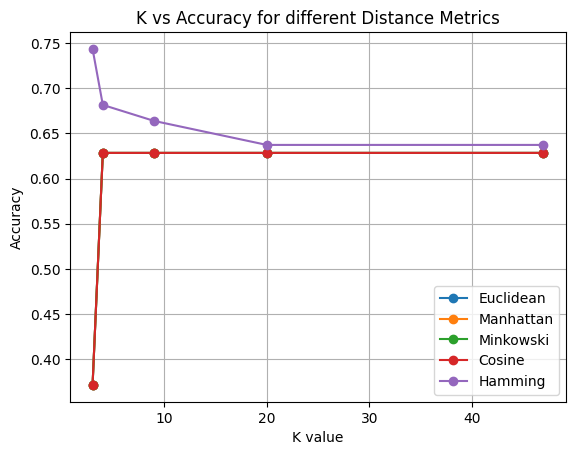

In [12]:
for name, acc in results.items():
    plt.plot(k_values, acc, marker='o', label=name)

plt.xlabel("K value")
plt.ylabel("Accuracy")
plt.title("K vs Accuracy for different Distance Metrics")
plt.legend()
plt.grid()
plt.show()

In [13]:
best_acc = 0
best_k = None
best_distance = None

for name, acc_list in results.items():
    for i, acc in enumerate(acc_list):
        if acc > best_acc:
            best_acc = acc
            best_k = k_values[i]
            best_distance = name

print("Best Accuracy:", best_acc)
print("Best K:", best_k)
print("Best Distance Metric:", best_distance)

Best Accuracy: 0.7433628318584071
Best K: 3
Best Distance Metric: Hamming


In [16]:
def confusion_matrix(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp, tn, fp, fn

best_func = distance_functions[best_distance]
y_best_pred = knn_predict(x_train, y_train, x_test, best_k, best_func)

tp, tn, fp, fn = confusion_matrix(y_test, y_best_pred)

precision = tp / (tp + fp)
recall = tp / (tp + fn)

print("Confusion Matrix:")
print([[tp, fp],
       [fn, tn]])

print("Precision:", precision)
print("Recall:", recall)


Confusion Matrix:
[[np.int64(24), np.int64(11)], [np.int64(18), np.int64(60)]]
Precision: 0.6857142857142857
Recall: 0.5714285714285714


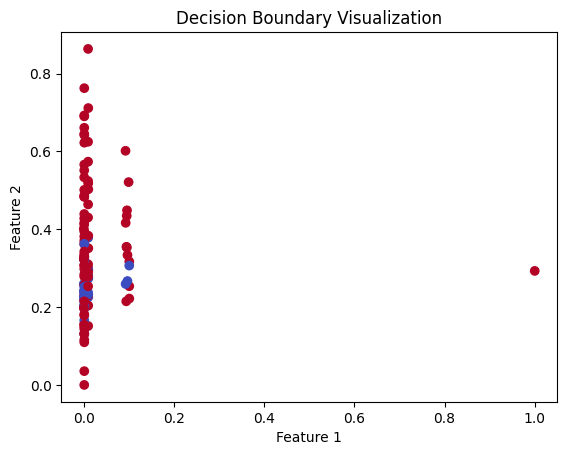

In [17]:
x_vis = x[:, :2]

x_train_v, x_test_v, y_train_v, y_test_v = train_test_split(x_vis, y)

y_pred_v = knn_predict(x_train_v, y_train_v, x_test_v, best_k, best_func)

plt.scatter(x_test_v[:,0], x_test_v[:,1], c=y_pred_v, cmap='coolwarm')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Decision Boundary Visualization")
plt.show()